# Задание 1. 
Имеется отрезок длины L.
- Написать алгоритм разбиения отрезка на более мелкие, при этом длина разбивающего отрезка должна увеличиваться от одного конца к другому.
- - Считать, что стартовый разбивающий отрезок задан и имеет длину l, а каждый последующий увеличивается в q раз (q>1). 
- При каких значениях l, q возможно точное разбиение для заданного L?
- - Если точное разбиение невозможно, написать алгоритм минимальной коррекции вводимых параметров l и q и обеспечить точное разбиение.

## Постановка задачи
По сути подобное разбиение отрезка L явзяется ни чем иным, как геометрической последовательностью вида L = l*sum(q^i) где i=0:n, n пренадлежит N.
Отсюда следует, что для того чтобы разбиение было возможно необходимо чтобы было возможным выполнение равенства суммы членов геометрической последовательности:
- L = l*(1-q^n)/(1-q)

Из этого равенства следует что:
- L > 0 (необходимо иначе задача выраждается)
- l > 0 (необходимо иначе равенство не будет выполнени)
- q > 1 (дано по условию задания)

Для решения второй части задания, а именно коррекции параметров l и q формамлизуем данную задачу, как задачу поиска параметров l, q и n таких, что расстояние между точками (l, q) и (l_optimal, q_optimal) былобы минимальным.

## Решение
### Загрузка библиотек

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
import random
import time
from numba import jit
from tqdm import tqdm

### Вспомогательные функции
#### Основные функции модели

In [7]:
# Вычисление L
# @jit
def culc_L(l,q,n):
    return l*((1-pow(q,n))/(1-q))

# Вычисление l
# @jit
def culc_l(L,q,n):
    return L*((1-q)/(1-pow(q,n)))

# Вычисление n
# @jit
def culc_n(L,l,q):
    return int(np.log(L*(q-1)+l)/np.log(q))

# Поиск с измельчением сетки
# @jit
def clarifying_search(params_zero, params_amplitude, iterations, mutator, grid_num, weights):
    params_previouse = params_zero[1:]
    for i in range(iterations):
        params_limits = param_border_modifier(params_previouse, params_amplitude)
        tmp_rez = grid_searching (params_zero, params_previouse, params_limits, grid_num, weights)
        if tmp_rez[1][0] < 0:
            break
        params_previouse = tmp_rez[1]
        params_amplitude = (mutator*params_amplitude[0], 
                            mutator*params_amplitude[1], 
                            int(mutator*params_amplitude[2]))
    # Поправка/уточнение решения за счёт l
    l2 = params_previouse[0]*params_zero[0]/culc_L(params_previouse[0],
                                                   params_previouse[1],
                                                   params_previouse[2])
    return (l2, params_previouse[1], params_previouse[2])

# Грубый поиск по сетке
# @jit
def grid_searching (params_zero, params_previouse, params_limits, grid_num , weights):
    # Создание сектки параметров на основании граничных значений и количества
    tmp = grid_maker(params_limits,params_previouse, grid_num)
    (l_grd, q_grd) = tmp[:2]
    (l_steps, q_steps, n_steps) = tmp[2:]
    # Хранилище ЦФ
    best_func = 10E20
    # Хранилище параметров
    best_l_q_n = (-1., -1., -1.)
    for n_grid in n_steps:
        func = (weights[0]*np.abs(culc_L(l_grd,q_grd,n_grid) - params_zero[0]) + # ЦФ сближающая L и L*
                weights[1]*np.abs(params_zero[1] - l_grd) + # ЦФ сближающая l и l*
                weights[2]*np.abs(params_zero[2] - q_grd))  # ЦФ сближающая q и q*
        idx = np.unravel_index(np.argmin(func, axis=None), func.shape)
        if func[idx] < best_func:
            best_l_q_n = (l_steps[idx[1]], q_steps[idx[0]], n_grid)
            best_func = func[idx[0],idx[1]]
    return (best_func,best_l_q_n)

# Расчет новых граничных значений
# @jit
def param_border_modifier(best_param, amp_param):
    # минимальная константа
    eps = 10E-10
    # определение новых граничных значений для l
    l = best_param[0]
    l_amp = amp_param[0]
    l_min = np.max([eps, l - l_amp])
    l_max = l_min + l_amp
    # определение новых граничных значений для q
    q = best_param[1]
    q_amp = amp_param[1]
    q_min = np.max([1 + eps, q - q_amp])
    q_max = q_min + q_amp
    # определение новых граничных значений для n
    n = best_param[2]
    n_amp = amp_param[2]
    n_min = int(np.max([1, n - n_amp]))
    n_max = n_min + int(n_amp)
    # Возвращение списка новых граничных значений
    return ((l_min,l_max), (q_min,q_max), (n_min,n_max))

# Создание сетки
# @jit
def grid_maker(params_limits, params_previouse, grid_num):
    step_treshhold = 10E-5
    # Предельные значения и шаг сетки l
    l_min, l_max = params_limits[0]
    l_step = np.max([step_treshhold,(l_max-l_min)/grid_num])
    # Предельные значения  и шаг сетки q
    q_min, q_max = params_limits[1]
    q_step = np.max([step_treshhold,(q_max-q_min)/grid_num])
    # Предельные значения  и шаг сетки n
    n_min, n_max = params_limits[2]
    n_step = np.max([1,(n_max-n_min)/grid_num]).astype(int)
    # Значения узлов сетки по каждому из параметров l,q,n
    l_steps = np.arange(l_min, l_max, l_step)
    q_steps = np.arange(q_min, q_max, q_step)
    n_steps = np.arange(n_min, n_max, n_step)  
    if params_previouse is None:
        l_steps = np.unique( l_steps )
        q_steps = np.unique( q_steps )
        n_steps = np.unique( n_steps.astype(int) )
    else:
        l_steps = np.sort( np.unique( np.append(l_steps,params_previouse[0]) ) )
        q_steps = np.sort( np.unique( np.append(q_steps,params_previouse[1]) ) )
        n_steps = np.sort( np.unique( np.append(n_steps,params_previouse[2]).astype(int) ) )
    # Сама сетка для l и q
    l_grid, q_grid = np.meshgrid(l_steps, q_steps, sparse=True)
    return l_grid, q_grid, l_steps, q_steps, n_steps

#### Функции для поиска оптимальных гиперпараметров модели

In [3]:
# Генерация тестовых данных
# @jit
def make_test_data():
    eps = 10E-10
    params_limits = param_border_modifier((1,2,1), (10E4,10E3,50))
    tmp = grid_maker(params_limits, None, 10)
    l_steps = tmp[2]
    q_steps = tmp[3]
    n_steps = tmp[4]
    test_data=[]
    l_stp=-1
    q_stp=-1
    n_stp=-1
    for l_val in l_steps:
        if l_stp < 0:
            l_stp = l_steps[1]-l_steps[0]
        for q_val in q_steps:
            if q_stp < 0:
                q_stp = q_steps[1]-q_steps[0]
            for n_val in n_steps:
                if n_stp < 0:
                    n_stp = n_steps[1]-n_steps[0]
                L = culc_L(l_val,q_val,n_val)
                if L<float("inf"):
                    l_noisy = np.max([eps, int(l_val + l_stp*(random.random()-0.5))])
                    q_noisy = np.max([1+eps, int(q_val + q_stp*(random.random()-0.5))])
                    abs_log_err = np.abs(np.log10(L)-np.log10(culc_L(l_noisy,q_noisy,n_val)))
                    if 0.5 < abs_log_err < 2 :
                        test_data.append((L,l_val,q_val,n_val,l_noisy,q_noisy))
    test_data = np.array(test_data)
    return test_data

# Оценивание конкретной модели на качество на основании набора данных
# @jit
def scoring_custom_model2(test_data, optim_params):
    iterations = optim_params[0] # = 10
    mutator = optim_params[1] # = 0.9
    grid_num = optim_params[2] # = 5
    par_amp_l = optim_params[3][0] # = (100., 20., 10)
    par_amp_q = optim_params[3][1]
    par_amp_n = optim_params[3][2]
    w_L = optim_params[4][0] # = [0.3,0.3,0.3]
    w_l = optim_params[4][1]
    w_q = optim_params[4][2]
    return scoring_custom_model(
        test_data, iterations, mutator, grid_num,
        par_amp_l, par_amp_q, par_amp_n, w_L, w_l, w_q)

# @jit
def scoring_custom_model(
    test_data, iterations, mutator, grid_num, 
    par_amp_l, par_amp_q, par_amp_n, w_L, w_l, w_q):
    params_amplitude = (par_amp_l, par_amp_q, par_amp_n)
    w = (w_L, w_l, w_q)
    errors = np.zeros([test_data.shape[0], 4])
    time_0 = time.time()
    for i in range (test_data.shape[0]):
        t_d = test_data[i,:]
        L = t_d[0]
        l = t_d[4]
        q = t_d[5]
        n = int(np.log(L*(q-1)+l)/np.log(q))
        params_zero = (L, l, q, n)
        rez = clarifying_search(params_zero, params_amplitude,
                                iterations, mutator, grid_num, w)
        errors[i,0] = np.abs(np.log(culc_L(rez[0],rez[1],rez[2])) - np.log(L))
        errors[i,1] = np.abs(t_d[1]-rez[0])
        errors[i,2] = np.abs(t_d[2]-rez[1])
        errors[i,3] = np.abs(t_d[3]-rez[2])
    time_elapsed = time.time()-time_0
    rez0 = [time_elapsed]
    rez0.extend(np.mean(errors,axis=0).tolist())
    return rez0

# # Поиск оптимальных весов
# test_data = make_test_data()
# print(test_data.shape[0])
# iterations = 40 # < 40 optimal
# mutator = 0.2 # <= 0.2 optimal
# grid_num = 21 #21 < 35 optimal
# params_amplitude = (15., 10., 5) # <= (50, 10, 5) optimal
# weights = (0.74, 0.13, 0.13) # weights_L > 0.6 optimal
# rezults_list = []
# params_list = []
# time1 = time.time()
# goal_list = []
# for amp_n in tqdm(params_amplitude_n):
#     for amp_l in params_amplitude_l:
#         for amp_q in params_amplitude_q:
#             optim_params = (
#                 iterations, # iterations
#                 mutator, # mutator
#                 grid_num, # grid_num
#                 (amp_l, amp_q, amp_n), # params_amplitude
#                 weights
#             )
#             params_list.append((amp_n, amp_l, amp_q))
#             tmp = scoring_custom_model2(test_data, optim_params)
#             rezults_list.append(tmp)
#             goal_list.append(np.log(tmp[0]*tmp[2]*tmp[3]))

# rezults_list = np.array(rezults_list)
# params_list = np.array(params_list)
# goal_list = np.array(goal_list)
# idx = np.where(params_list[:,2]<=10)
# idx2 = np.where( params_list[idx[0],1]<=50)
# idx = idx[0][idx2]
# i = 0
# y = rezults_list[idx,i]
# # y = rezults_list[idx,0]*rezults_list[idx,3]
# plt.scatter(params_list[idx,0],y)
# plt.show()
# plt.scatter(params_list[idx,1],y)
# plt.show()
# plt.scatter(params_list[idx,2],y)
# plt.show()

### Входные данные

In [4]:
# Даны
L = 250.
l = 3.2
q = 5.1
print('L: ' + str(L) + '\n' + 'l: ' + str(l) + '\n' + 'q: ' + str(q))

L: 250.0
l: 3.2
q: 5.1


### Коррекция l и q

In [5]:
# Определение оптимальных l и q, а так же нахождение n
n = culc_n(L,l,q)
params_zero = (L, l, q, n)
params_amplitude = (45., 10., 5)
iterations = 30
mutator = 0.15
grid_num = 30
weights = (0.74, 0.13, 0.13)
(l_optim, q_optim, n_optim) =clarifying_search(params_zero, params_amplitude, iterations, mutator, grid_num, weights)
print('l_optim: ' + str(np.round(l_optim,4)) + '\n' +
       'q_optim: ' + str(np.round(q_optim,4)) + '\n' +
        'n_optim: ' + str(n_optim))

l_optim: 3.8294
q_optim: 7.5333
n_optim: 3


### Разбиение на отрезки

In [20]:
print('Пусть отрезок L начинается от 0 и находится в положительной области и имеет координаты:')
print(np.round(np.array((0,L)),2))
segments_list = []
previous_segment_end = 0.
for n_iter in range(n_optim):
    segmet_end = previous_segment_end + l_optim*q_optim**n_iter
    segments_list.append((previous_segment_end, segmet_end))
    previous_segment_end = segmet_end
segments = np.array(segments_list)
print('Тогда, список координат отрезков разбиения следующий:')
print(np.round(segments,2))


Пусть отрезок L начинается от 0 и находится в положительной области и имеет координаты:
[  0. 250.]
Тогда, список координат отрезков разбиения следующий:
[[  0.     3.83]
 [  3.83  32.68]
 [ 32.68 250.  ]]


# Задание 2.
Имеется набор 𝑁 векторов из двумерного пространства. Известно, что x, y координаты M векторов равномерно распределены на [0,1], а концы других 𝑁−𝑀 векторов образуют в пространстве ℝ2 кривую вида 𝑥2/𝑎2 + 𝑦2/𝑏2 + 𝑛 = 1, где n - нормальный шум с нулевым средним и дисперсией ≪𝑎,𝑏. Метки классов выставлены случайно неверно в 5% случаев для каждого класса.
- Необходимо разработать линейно-регрессионную модель, определяющая, к какому из двух классов принадлежит каждая точка из представленного множества.

Замечание:
- Алгоритм не должен опираться на априорные знания о виде описанной выше кривой.

## Постановка задачи
Данную задачу можно переформулировать иначе:
В думерном пространстве дано N точек пренадлежащих 2-м классм.
Первому классу пренадлежат точки находящиеся квадрату в верхней правой четверти со стороной 1  и координатами вершин (0,0), (0,1), (1,1) и (1,0).

Второму классу пренадлежат точки лежащие на элепсе с длиной a и шириной b со смещением n, где n имеет нормальное распределение с мат.ожиданием 0 и дисперсией ≪ min(𝑎,𝑏).
Так же известно что метки классов выставлены с ошибкой в 5%.

В качестве критерия пренадлежности к классу предлагается граничное значение:
- x1,x2,...,x_m 

Необходимо:
- Найти оптимальную прямую и минимальное количество точек переключения m, такие что ошибка на проверочной выборке была бы минимальной.

In [231]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score

In [215]:
def ellipseM_x(y,a,b,n):
    return a*(np.max([y*0, 1 - n - y**2/b**2], axis=0))**0.5

def ellipseM_y(x,a,b,n):
    return b*(np.max([x*0, 1 - n - x**2/a**2], axis=0))**0.5
    
def make_test_data(N_num= 1000, a= 4, b= 2, proportion= 0.5 , error_proportion= 0.05):
    M_num = int(N_num*proportion)
    M_num_prop_x = int(b/(a+b)*M_num)
    M_num_prop_y = M_num - M_num_prop_x
    M = np.zeros([M_num,3])
    n_var = np.min([a,b])/9
    n = np.random.normal(0, n_var, M_num)
    rand_sign = 2*(np.random.uniform(0, 1, [M_num,1])>0.5).astype(int)-1 
    rand_x = np.random.uniform(-a, a, M_num_prop_x)
    M[:M_num_prop_x,:2] = rand_sign[:M_num_prop_x]*np.array([rand_x, ellipseM_y(rand_x,a,b,n[:M_num_prop_x])]).T
    rand_y = np.random.uniform(-b, b, M_num_prop_y)
    M[M_num_prop_x:,:2] = rand_sign[M_num_prop_x:]*np.array([ellipseM_x(rand_y,a,b,n[M_num_prop_x:]), rand_y]).T
    M[:,2] = 1
    M[np.random.choice(M_num, int(M_num*error_proportion)), 2] = 0
    K_num = N_num - M_num
    K = np.concatenate((np.random.uniform(0,1,[K_num,2]), np.zeros([K_num,1])), axis=1)    
    K[np.random.choice(K_num, int(K_num*error_proportion)), 2] = 1
    return np.concatenate((M, K), axis=0)

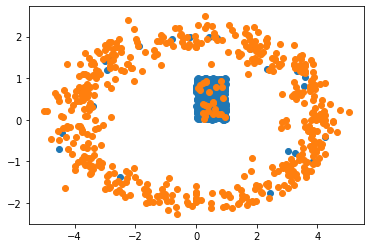

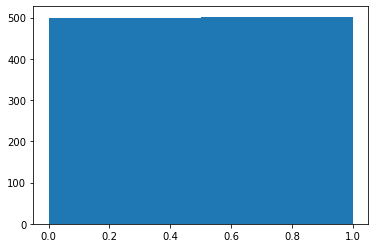

In [221]:
X = N[:,:2]
y = N[:,2]
N = make_test_data()
plt.scatter(N[N[:,2]==0,0], N[N[:,2]==0,1])
plt.scatter(N[N[:,2]==1,0], N[N[:,2]==1,1])
plt.show()
plt.hist(N[:,2],bins=2)
plt.show()

In [232]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=1./3)

In [245]:
C = 1.0  # = self._alpha in our algorithm
model1 = svm.SVC(kernel='linear', C=C)
model2 = svm.LinearSVC(C=C, max_iter=10000)
model3 = svm.SVC(kernel='rbf', gamma=0.7, C=C)
model4 = svm.SVC(kernel='poly', degree=3, gamma='auto', C=C)
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)
model4.fit(X_train, y_train)

SVC(gamma='auto', kernel='poly')

0.6345381526104418


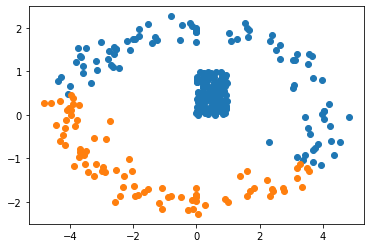

In [246]:
y_pred = model1.predict(X_test)
print(f1_score(y_test, y_pred))
plt.scatter(X_test[y_pred==0,0],X_test[y_pred==0,1])
plt.scatter(X_test[y_pred==1,0],X_test[y_pred==1,1])
plt.show()

0.6282051282051282


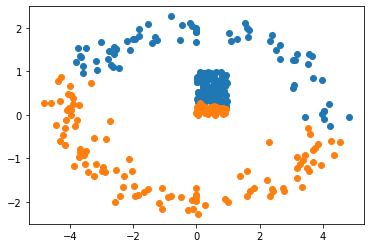

In [248]:
y_pred = model2.predict(X_test)
print(f1_score(y_test, y_pred))
plt.scatter(X_test[y_pred==0,0],X_test[y_pred==0,1])
plt.scatter(X_test[y_pred==1,0],X_test[y_pred==1,1])
plt.show()

0.9526627218934911


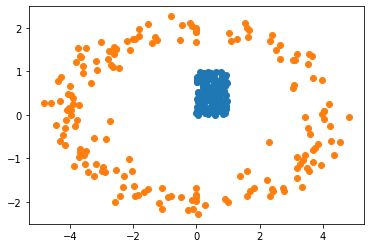

In [249]:
y_pred = model3.predict(X_test)
print(f1_score(y_test, y_pred))
plt.scatter(X_test[y_pred==0,0],X_test[y_pred==0,1])
plt.scatter(X_test[y_pred==1,0],X_test[y_pred==1,1])
plt.show()

0.45454545454545453


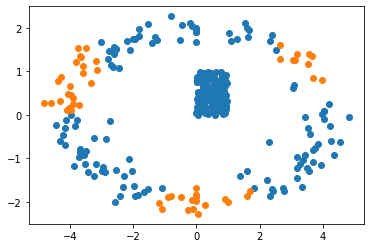

In [250]:
y_pred = model4.predict(X_test)
print(f1_score(y_test, y_pred))
plt.scatter(X_test[y_pred==0,0],X_test[y_pred==0,1])
plt.scatter(X_test[y_pred==1,0],X_test[y_pred==1,1])
plt.show()

## Задание 3.
- Написать алгоритм генерации бинарного изображения, содержащее непересекающиеся произвольные (разной геометрии и размеров) треугольники и прямоугольники.
- Необходимо распознать и повернуть все треугольники на изображении на 45 градусов относительно своих центров масс.
- Учесть наличие пересечения поворачиваемых фигур: если поворот невозможен без пересечения, выдавать предупреждение.

Замечание:
- Запрещено пользоваться готовыми функциями из пакетов image processing.

## Задание 4.
На сайте Мирового Центра Данных по Солнечно-Земной Физике (http://www.wdcb.ru/stp/solar/sunspots.ru.html) имеется датасет с ежедневными измерениями числа солнечных пятен. 
- На основе данных с 1944 г по наст. вр. необходимо создать и обучить предиктивную модель, выдающую прогноз числа солнечных пятен на сроки 1, 10 и 30 дней от требуемой даты.
- Обосновать выбор модели и ее гиперпараметров и оценить качество полученных результатов

## Данные
- Daily total sunspot number:
- - SunspotNumber \ SN_d_tot_V2.0.csv
- Monthly mean total sunspot number:
- - SunspotNumber \ SN_m_tot_V2.0.csv
- Monthly smoothed (13-month) total sunspot number:
- - SunspotNumber \ SN_ms_tot_V2.0.csv
- Yearly mean total sunspot number:
- - SunspotNumber \ SN_y_tot_V2.0.csv